In [166]:
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults
)

from gillespie.sir import (
    SIRG,
    histogram_data_SIRG,
    plot_histogram_SIRG
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
# notebook parameters
n_dimensions = 2
random_seed = 1

# SIR model paramters
k1, k2, k3 = 1, 1, 0
N = 1024

# training data parameters
n_trajectories = 250
n_time_per_trajectory = 4
time_step = 1e-3
n_skip_steps = 10 # how many time steps to skip of the training data, to artificially increase time step


In [176]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**6, 
                                M_min=10,
                                M_max=200,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


In [177]:
# approx sde system true drift and diffusion
def true_drift(x):
    theta0 = np.clip(x[:, 0], 0, 1)
    theta2 = np.clip(x[:, 1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    return np.stack([-r1, r2], axis=1)


def true_diffusion(x):
    theta0 = np.clip(x[:, 0], 0, 1)
    theta2 = np.clip(x[:, 1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    epsilon = 1e-8
    return np.transpose(np.array([[np.sqrt(r1/N + epsilon), np.zeros(x.shape[0])], [np.zeros(x.shape[0]), np.sqrt(r2/N + epsilon)]]))


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


(23021, 2)
drift epoch: 61


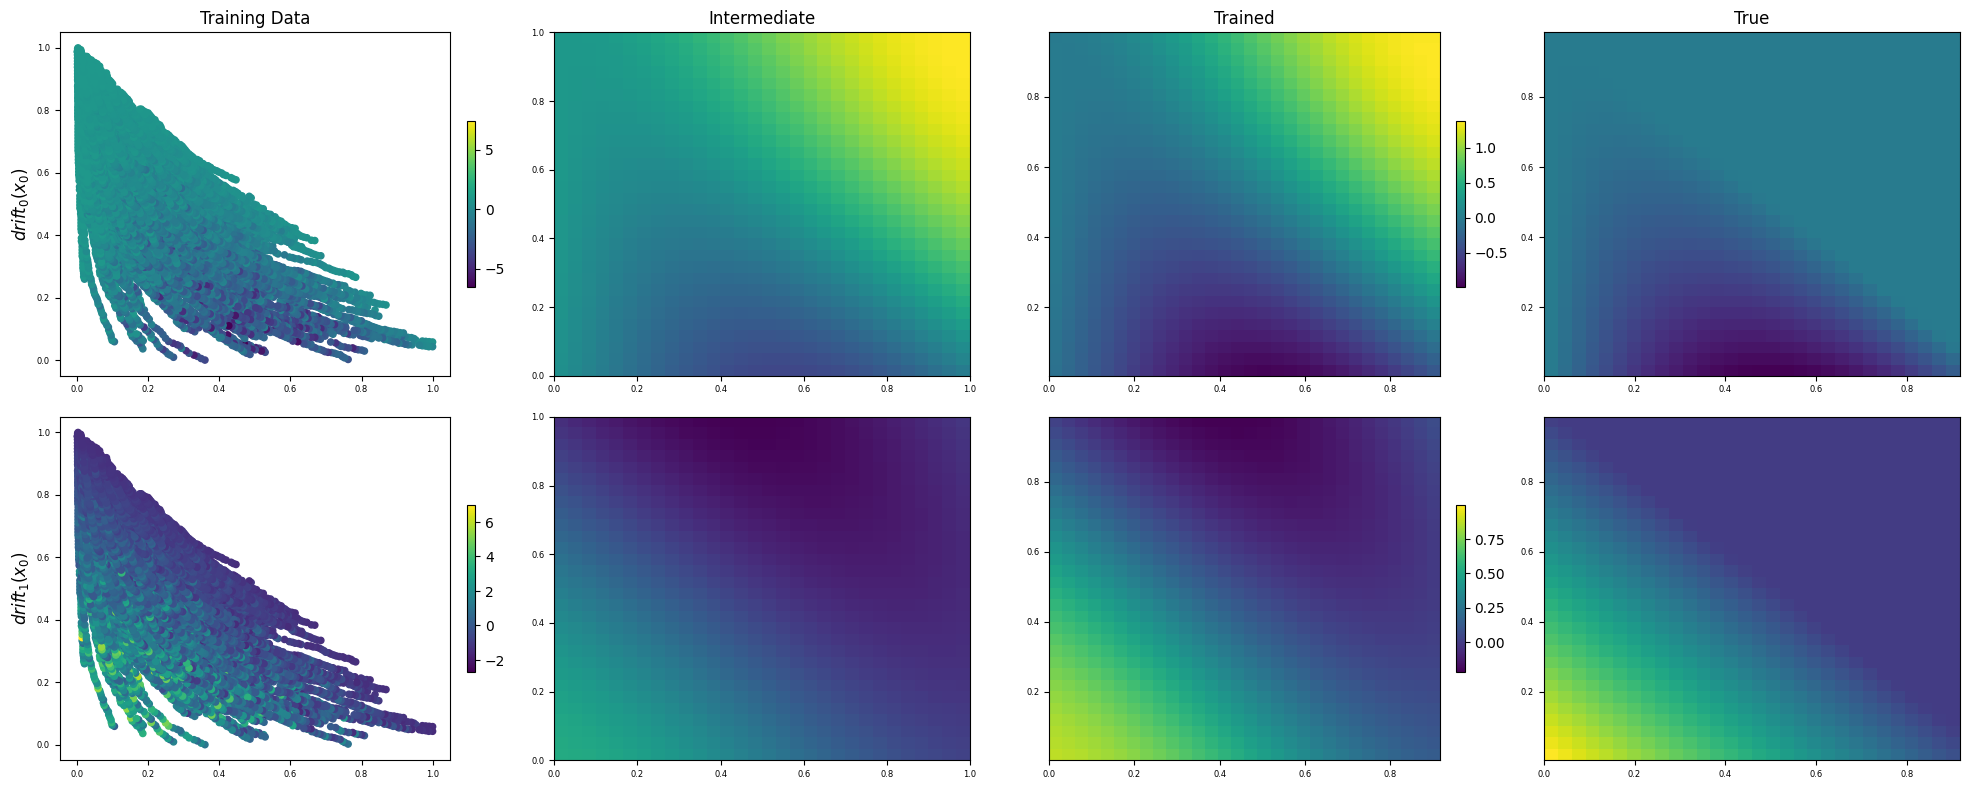

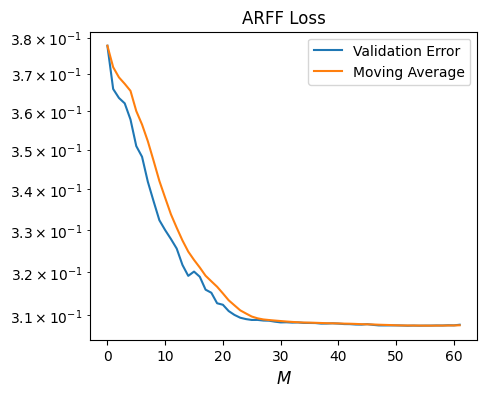

diff epoch: 25


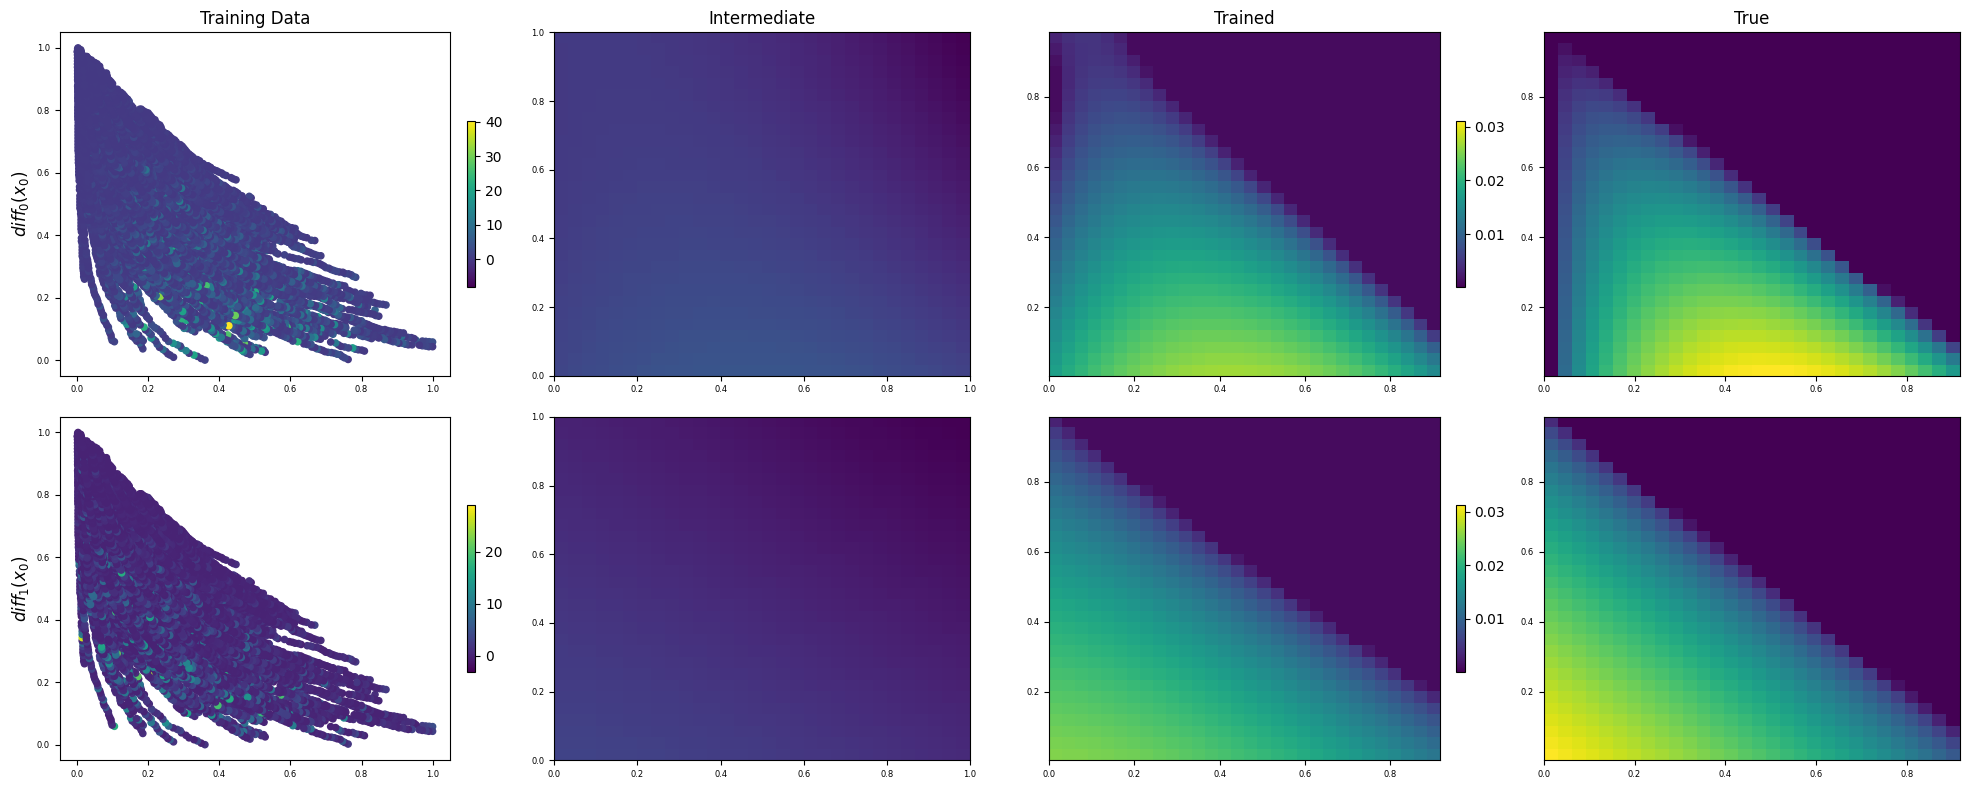

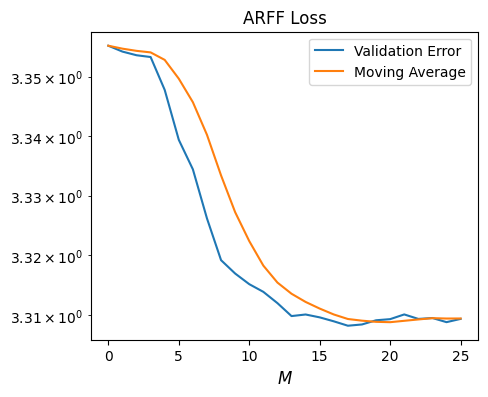

Observed loss: -9.807519690270572
Observed validation loss: -9.812344174444673
Training time: 11.64480447769165


In [181]:
# train networks
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    # generate data
    sirg = SIRG(N=N, k1=k1, k2=k2, k3=0, random_state=(random_seed + i))
    x_data, y_data, step_sizes = sirg.sample_data_SIRG(n_trajectories, n_time_per_trajectory, time_step, n_skip_steps)
    print(x_data.shape)
    
    # build network
    rng = np.random.default_rng(random_seed + i)
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, rng=rng, resampling=True)

    # train network
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
    
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

True function loss: -9.829809461175408
figures_per_row 2


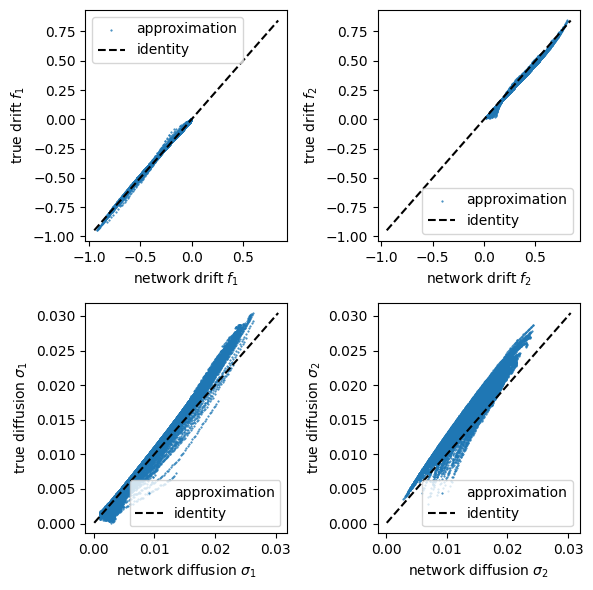

In [182]:
# calculate theoretical mean min loss (integral over loss function across input domain)
true_loss = SAT.get_loss(x_data, y_data, x_data, step_sizes, true_drift, true_diffusion).numpy()
print('True function loss:', true_loss)
save_min_loss = False
if save_min_loss:
    output_dir = os.path.join(script_dir, 'saved_results/loss_v_time_data')
    output_path = os.path.join(output_dir, f"{filename}_SS{n_skip_steps}_min_loss.txt")
    with open(output_path, 'w') as file:
        file.write(f"{MML}\n")

# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_skip_steps)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=False)

PR.plot_results_functions(SAT.drift_diffusion, true_drift_diffusion, x_data, save=False)


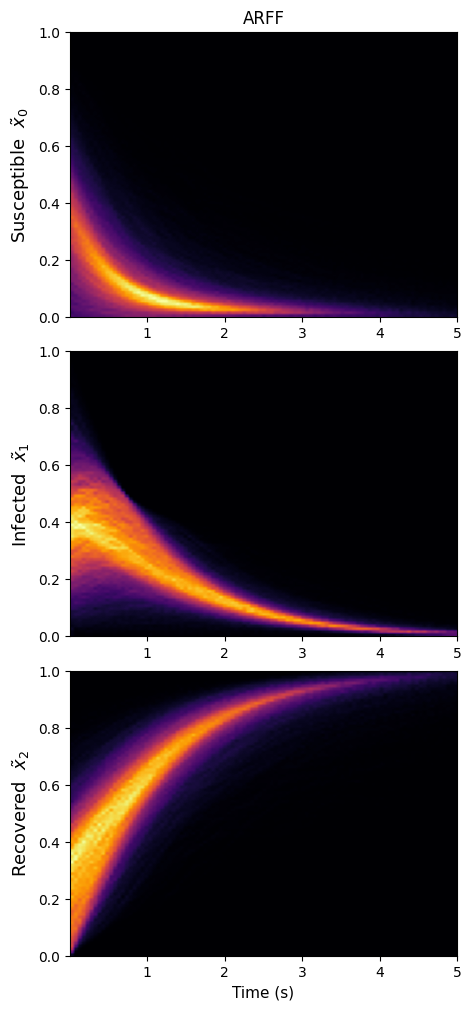

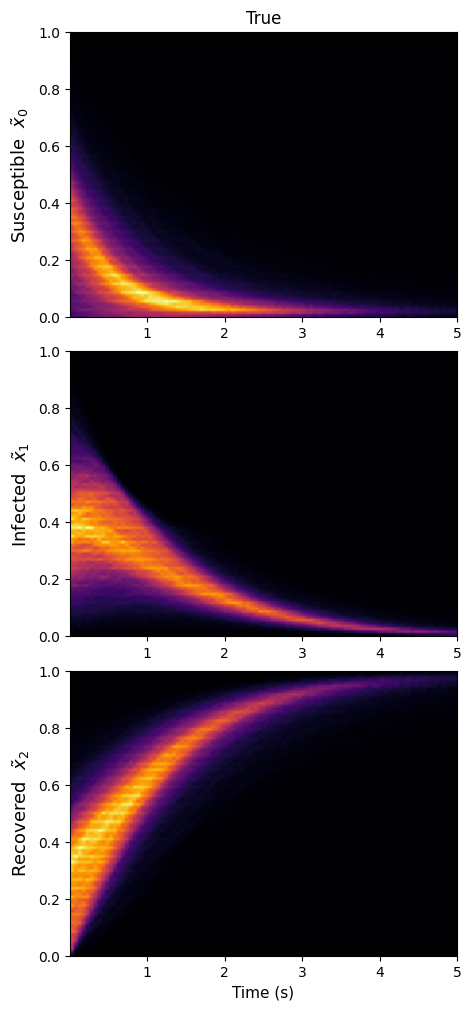

In [172]:
# plot histograms
n_trajectories_hist = 10000
n_time_per_trajectory_hist = 5
time_step_hist = 1e-3
n_skip_steps_hist = 10

y, time_g = sirg.generate_trajectories(n_trajectories_hist, n_time_per_trajectory_hist, time_step_hist, n_skip_steps_hist)
X, time_g_layered = histogram_data_SIRG(SAT.drift_diffusion, y, time_g, n_dimensions, rng, ARFF=True)

plot_histogram_SIRG(X, time_g_layered, n_time_per_trajectory, 'ARFF', script_dir, filename, n_skip_steps, save=False)
plot_histogram_SIRG(y, time_g, n_time_per_trajectory, 'True', script_dir, filename, n_skip_steps, save=False)